<a href="https://colab.research.google.com/github/vincelemke99/Bachelor-Thesis/blob/main/lead_predication_final_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas category_encoders scikit-learn --q




In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Import machine learning libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

In [ ]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

Authenticated


In [ ]:
PROJECT_ID = 'prj-snd-ew3-vschmitt'

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

In [ ]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'lead_prediction'
BQ_TABLE = 'trainings_data_raw'

In [ ]:
# SQL query to select data
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""

try:
    # Execute the query and convert the result to a pandas DataFrame
    df = client.query(query=query).to_dataframe()
    print("Query executed successfully and DataFrame is ready.")
except Exception as e:
    print(f"An error occurred: {e}")

Query executed successfully and DataFrame is ready.


In [ ]:
df.shape

(1147606, 28)

In [ ]:
# Identify duplicate lead_ids
duplicate_lead_ids = df[df.duplicated('lead_id', keep=False)]['lead_id'].unique()

# Filter rows to drop
rows_to_drop = df[(df['lead_id'].isin(duplicate_lead_ids)) & (df['is_converted'] == False)]

# Drop rows
# Keep only unique lead_ids (this is optional if the above steps suffice)
df = df.drop_duplicates(subset='lead_id')

In [ ]:
df.shape

(184738, 28)

In [ ]:
df.head()

,lead_id,domain,name,has_phone,geschlecht,lead_source,lead_quelle_detail,produkt_zeitraum_c,produkt_art_der_ausbildung_c,product_interest_type,...,ManualTerm,Browser,Operating_System,Device,Language,ManualAdContent,bounce,accept_data_policy,pageviews,Device_Category
0,00Q7U0000015pHTUAY,gmail.com,normal,False,männlich,Organisch,Google,Berufsbegleitend,Weiterbildung,None,...,None,None,None,None,None,None,None,Keine Zustimmung,<NA>,None
1,00Q7U000004R4BXUA0,web.de,normal,False,weiblich,Organisch,Google,Berufsbegleitend,Weiterbildung,Infomaterial,...,None,None,None,None,None,None,None,Keine Zustimmung,<NA>,None
2,00Q7U00000PtBclUAF,web.de,normal,True,weiblich,Direkt,amdnet.de,Berufsbegleitend,Weiterbildung,Infomaterial,...,None,None,None,None,None,None,None,Offene Zustimmung,<NA>,None
3,00Q7U00000OurguUAB,gmail.com,normal,False,weiblich,Direkt,amdnet.de,Berufsbegleitend,Weiterbildung,Infomaterial,...,None,None,None,None,None,None,None,Offene Zustimmung,<NA>,None
4,00Q7U00000HwFyPUAV,gmail.com,normal,False,männlich,Paid Social,Meta Ads,Berufsbegleitend,Weiterbildung,Infomaterial,...,feed ads,Safari (in-app),iOS 16.4.1,iPhone 12,en-us,ads,true,Keine Zustimmung,1,mobile


In [ ]:
df.drop(['lead_id',], axis="columns", inplace=True)

In [ ]:
df.drop(['pageviews',], axis="columns", inplace=True)

In [ ]:
df.rename(columns={'name': 'Name_Describe','geschlecht' : 'Gender', 'produkt_zeitraum_c' : 'Study_Model',
       'produkt_art_der_ausbildung_c' : 'Type_of_Study_Program', 'produkt_standort' : 'Study_Location',
       'produkt_fachbereich' : 'Faculty', 'produkt_name': 'Study_Program','product_interest_type' : 'Conversion_Type',
       'lead_quelle_detail' : 'Lead_Source_Detail', 'domain': 'Domain', 'has_phone' : 'has_Phone', 'lead_source' : 'Lead_Source', 'pagepath': 'Pagepath', 'time_OnSite' : 'Time_on_Site' , 'bounce' : 'Bounce', 'semester':'Semester', 'host': 'Host'},inplace=True)
df.head()

,Domain,Name_Describe,has_Phone,Gender,Lead_Source,Lead_Source_Detail,Study_Model,Type_of_Study_Program,Conversion_Type,Study_Location,...,Time_on_Site,ManualTerm,Browser,Operating_System,Device,Language,ManualAdContent,Bounce,accept_data_policy,Device_Category
0,gmail.com,normal,False,männlich,Organisch,Google,Berufsbegleitend,Weiterbildung,None,Düsseldorf,...,<NA>,None,None,None,None,None,None,None,Keine Zustimmung,None
1,web.de,normal,False,weiblich,Organisch,Google,Berufsbegleitend,Weiterbildung,Infomaterial,Düsseldorf,...,<NA>,None,None,None,None,None,None,None,Keine Zustimmung,None
2,web.de,normal,True,weiblich,Direkt,amdnet.de,Berufsbegleitend,Weiterbildung,Infomaterial,Düsseldorf,...,<NA>,None,None,None,None,None,None,None,Offene Zustimmung,None
3,gmail.com,normal,False,weiblich,Direkt,amdnet.de,Berufsbegleitend,Weiterbildung,Infomaterial,Berlin,...,<NA>,None,None,None,None,None,None,None,Offene Zustimmung,None
4,gmail.com,normal,False,männlich,Paid Social,Meta Ads,Berufsbegleitend,Weiterbildung,Infomaterial,München,...,0,feed ads,Safari (in-app),iOS 16.4.1,iPhone 12,en-us,ads,true,Keine Zustimmung,mobile


In [ ]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
ManualTerm,129475
ManualAdContent,128424
Device,127906
Language,127564
Operating_System,127564
Browser,127564
Time_on_Site,127564
Bounce,127564
Device_Category,127564
Host,36720


In [ ]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
ManualTerm,70.085743
ManualAdContent,69.516829
Device,69.236432
Language,69.051305
Operating_System,69.051305
Browser,69.051305
Time_on_Site,69.051305
Bounce,69.051305
Device_Category,69.051305
Host,19.876798


In [ ]:
# List of columns to check for missing values
columns_to_check = [
    'ManualTerm', 'ManualAdContent', 'Device', 'Device_Category',
     'Bounce', 'Language', 'Operating_System', 'Browser', 'Time_on_Site'
]

# Drop rows with missing values in the specified columns
df = df.dropna(subset=columns_to_check)

In [ ]:
df.shape

(54934, 26)

In [ ]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Conversion_Type,6111
Gender,280
Name_Describe,0
Domain,0
Lead_Source,0
has_Phone,0
Lead_Source_Detail,0
Study_Model,0
Type_of_Study_Program,0
Study_Location,0


In [ ]:
df['accept_data_policy'].value_counts()

accept_data_policy
Keine Zustimmung     25920
Offene Zustimmung    16725
Zustimmung           12289
Name: count, dtype: int64

In [ ]:
df['accept_data_policy'] = df['accept_data_policy'].replace({
        'Offene Zustimmung': 'Keine Zustimmung',
        'Mixed Mode': 'Berufsbegleitend'
  })

In [ ]:
df['accept_data_policy'].value_counts()

accept_data_policy
Keine Zustimmung    42645
Zustimmung          12289
Name: count, dtype: int64

In [ ]:
df['Conversion_Type'].value_counts()

Conversion_Type
Infomaterial    46930
Infoabend        1893
Name: count, dtype: int64

In [ ]:
df['Gender'].value_counts()

Gender
weiblich        41003
männlich        13636
keine Angabe       15
Name: count, dtype: int64

In [ ]:
df['Gender'] = df['Gender'].fillna('weiblich')

In [ ]:
df['ManualAdContent'] = df['ManualAdContent'].fillna('ads')

In [ ]:
  # Replace "Duales Studium" and "Mixed Mode" with "Berufsbegleitend"
df['Study_Model'] = df['Study_Model'].replace({
        'Duales Studium': 'Berufsbegleitend',
        'Mixed Mode': 'Berufsbegleitend'
  })

In [ ]:
df.describe()

,Time_on_Site
count,54934.0
mean,2623.909328
std,8129.992174
min,0.0
25%,0.0
50%,32.0
75%,482.0
max,83521.0


In [ ]:
df['Time_on_Site'] = df['Time_on_Site'].fillna(36)

In [ ]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Conversion_Type,6111
Domain,0
Name_Describe,0
has_Phone,0
Lead_Source,0
Gender,0
Lead_Source_Detail,0
Study_Model,0
Type_of_Study_Program,0
Study_Location,0


In [ ]:
df.shape

(54934, 26)

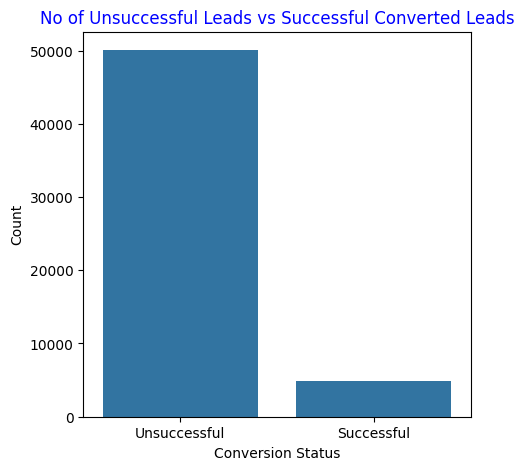

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x='is_converted', data=df)
plt.title('No of Unsuccessful Leads vs Successful Converted Leads', color='blue')
plt.xticks(np.arange(2), ('Unsuccessful', 'Successful'))
plt.xlabel('Conversion Status')
plt.ylabel('Count')
plt.show()

In [ ]:
total_leads = len(df)
successful_leads = df['is_converted'].sum()
conversion_rate = (successful_leads / total_leads) * 100
print(f'Conversion Rate: {conversion_rate:.2f}%')

Conversion Rate: 8.87%


In [ ]:
# Creating a crosstab DataFrame for demonstration
crosstab_df = pd.crosstab(index=df['Lead_Source'], columns='count')

In [ ]:
def plot_frequency_and_percentage(feature, df, category_df, another_row=False, height=8, ylabels=[]):
    if another_row:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, height * 2))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Get top 5 categories by frequency
    top_categories = category_df[feature].value_counts().nlargest(5).index

    # Frequency plot for top 5 categories
    ax1.set_title(f'Frequency Plot of {feature}', color='blue')
    ax1.set_ylabel(feature)
    ax1.set_xlabel('count')
    sns.countplot(y=feature, data=category_df[category_df[feature].isin(top_categories)],
                  order=top_categories, ax=ax1, color='green')
    if ylabels:
        ax1.set_yticklabels(ylabels)

    # Calculate count of converted leads for top 5 categories
    converted_counts = df[df['is_converted'] == True][feature].value_counts()
    converted_counts = converted_counts[converted_counts.index.isin(top_categories)]

    # Converted leads plot for top 5 categories
    ax2.set_title('Converted Leads Count', color='blue')
    ax2.set_ylabel(feature)
    ax2.set_xlabel('count')
    converted_counts.sort_values().plot(kind='barh', ax=ax2, color='orange')
    if ylabels:
        ax2.set_yticklabels(ylabels)

    # Calculate and display overall conversion rate
    total_leads = len(df)
    successful_leads = df['is_converted'].sum()
    conversion_rate = (successful_leads / total_leads) * 100
    fig.suptitle(f'Overall Conversion Rate: {conversion_rate:.2f}%', fontsize=14, color='red')


plt.show()

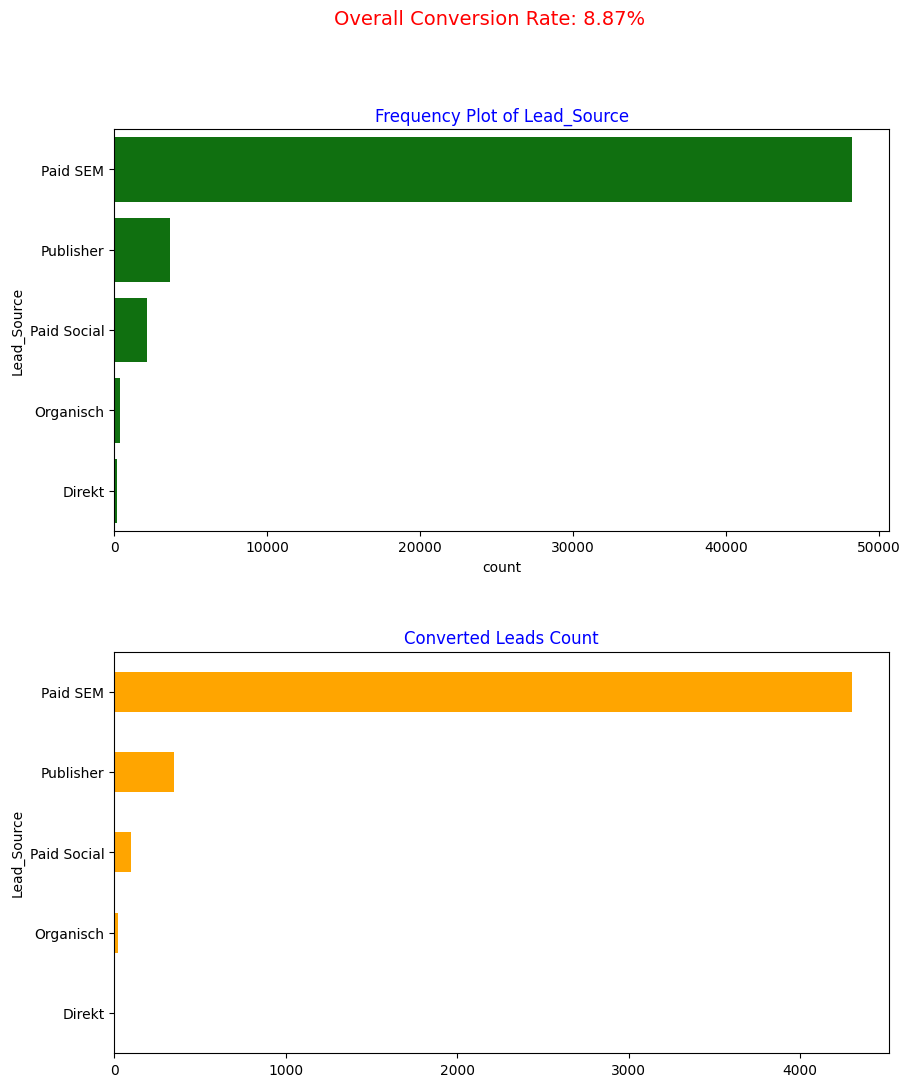

In [ ]:
plot_frequency_and_percentage('Lead_Source', df, df, True, 6)

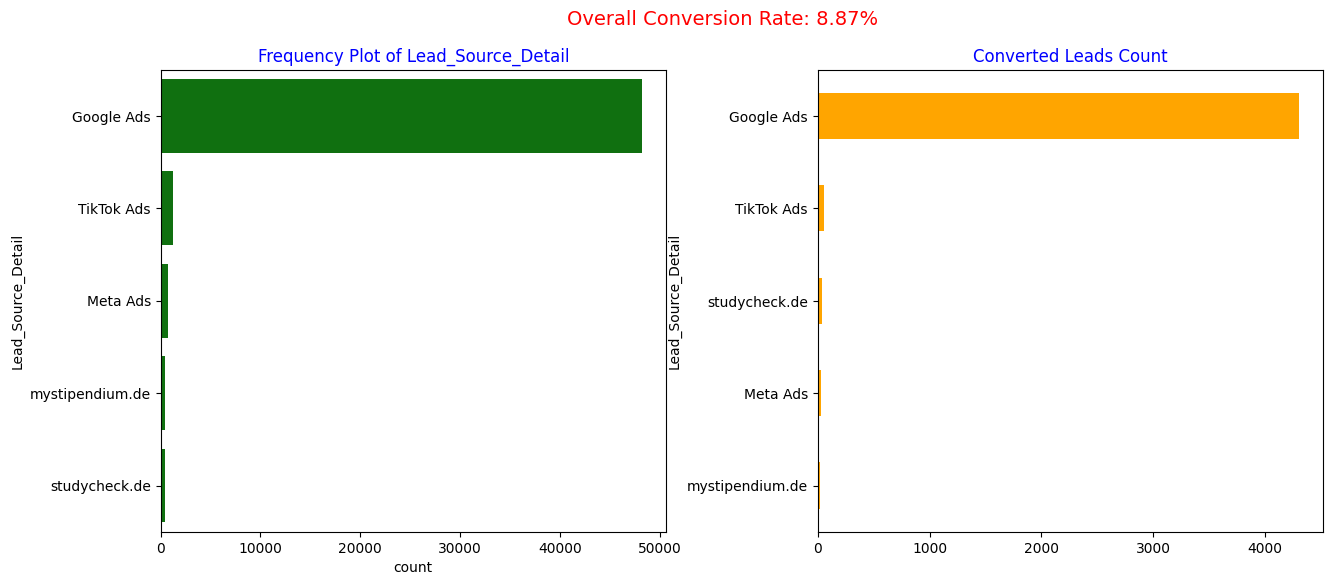

In [ ]:
#plot_frequency_and_percentage('Lead_Source_Detail', df, df, True, 6)
plot_frequency_and_percentage('Lead_Source_Detail', df, df, another_row=False, height=8, ylabels=[])

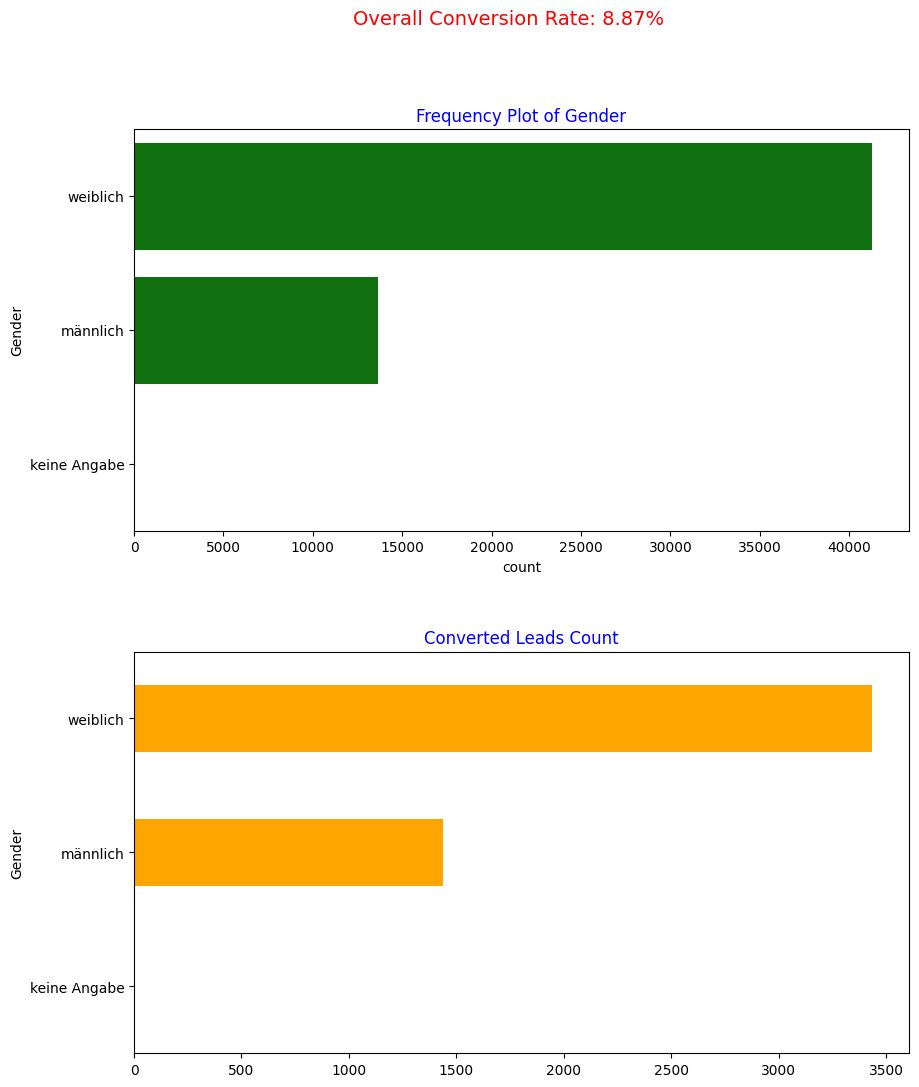

In [ ]:
plot_frequency_and_percentage('Gender', df, df, True, 6)

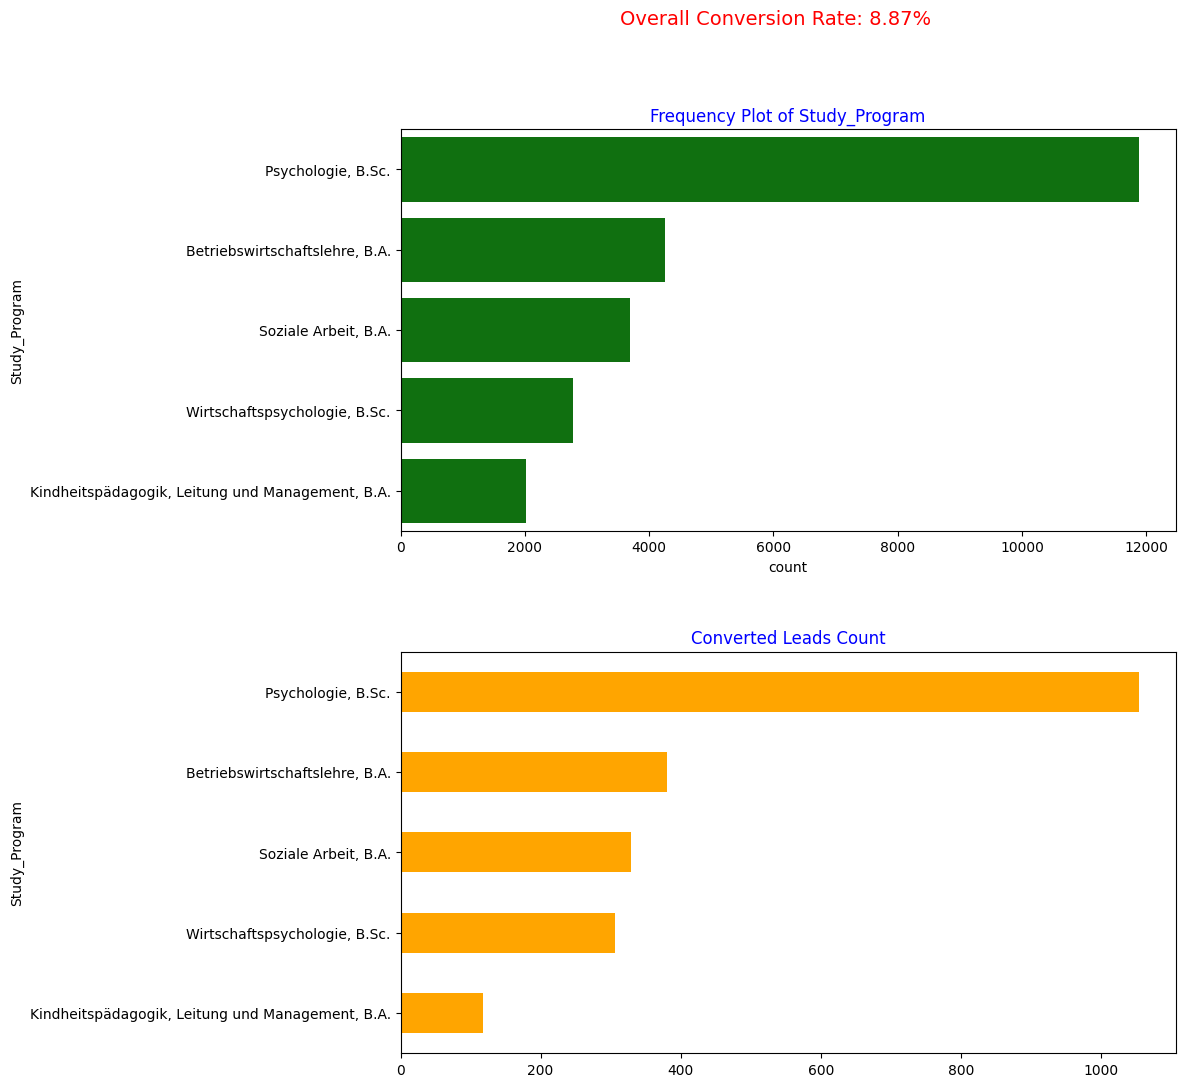

In [ ]:
plot_frequency_and_percentage('Study_Program', df, df, True, 6)

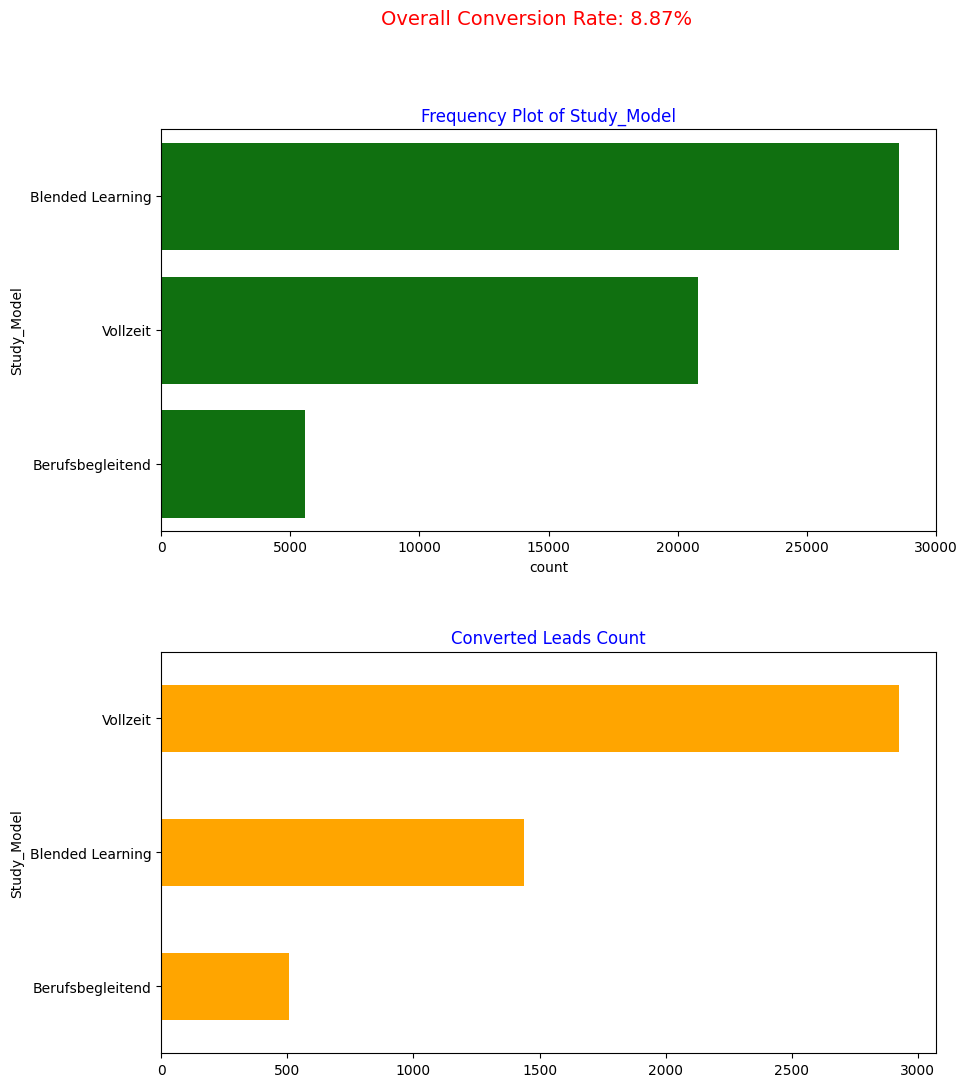

In [ ]:
plot_frequency_and_percentage('Study_Model', df, df, True, 6)

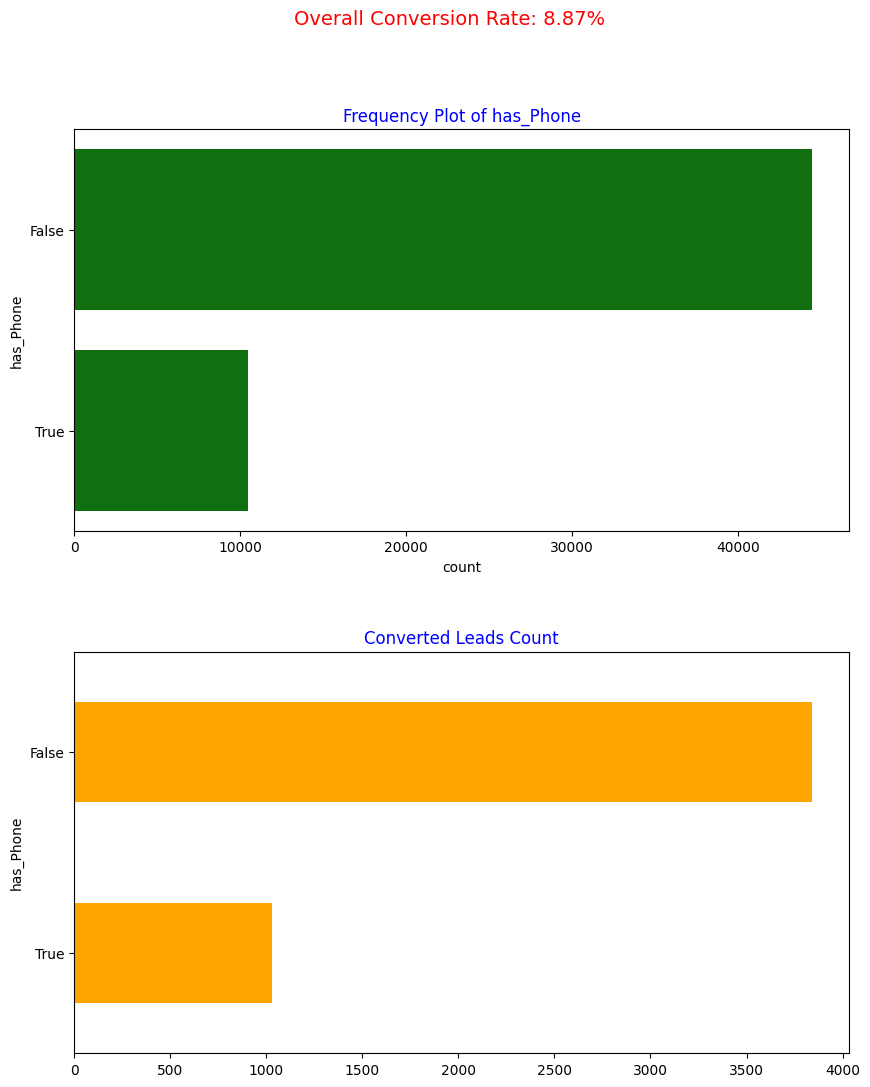

In [ ]:
plot_frequency_and_percentage('has_Phone', df, df, True, 6)

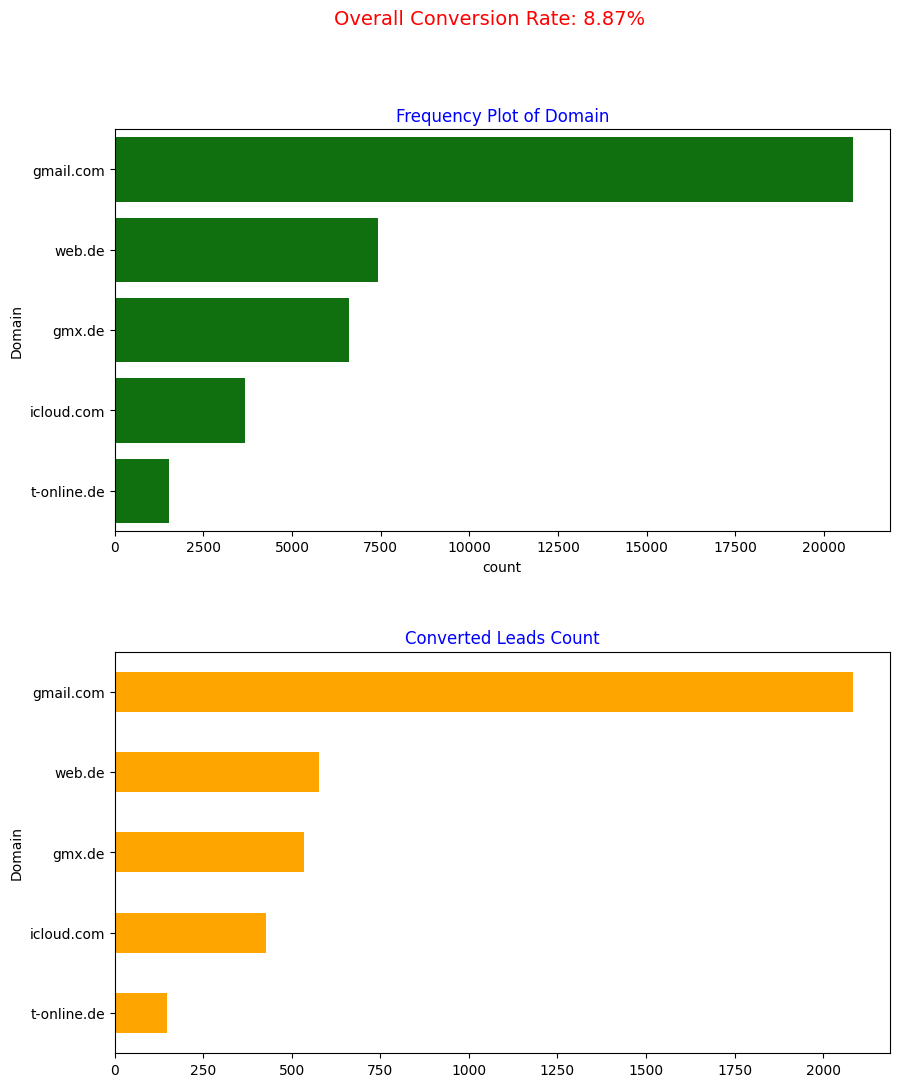

In [ ]:
plot_frequency_and_percentage('Domain', df, df, True, 6)

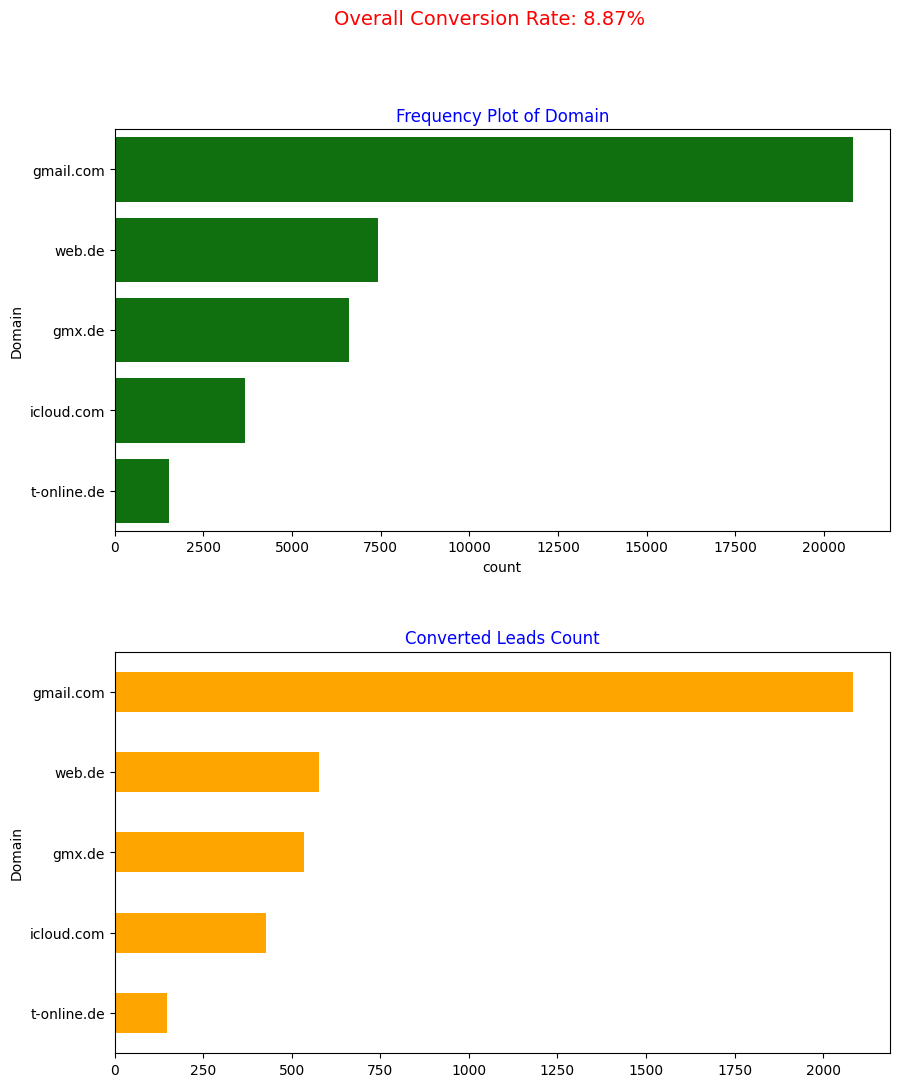

In [ ]:
plot_frequency_and_percentage('Domain', df, df, True, 6)

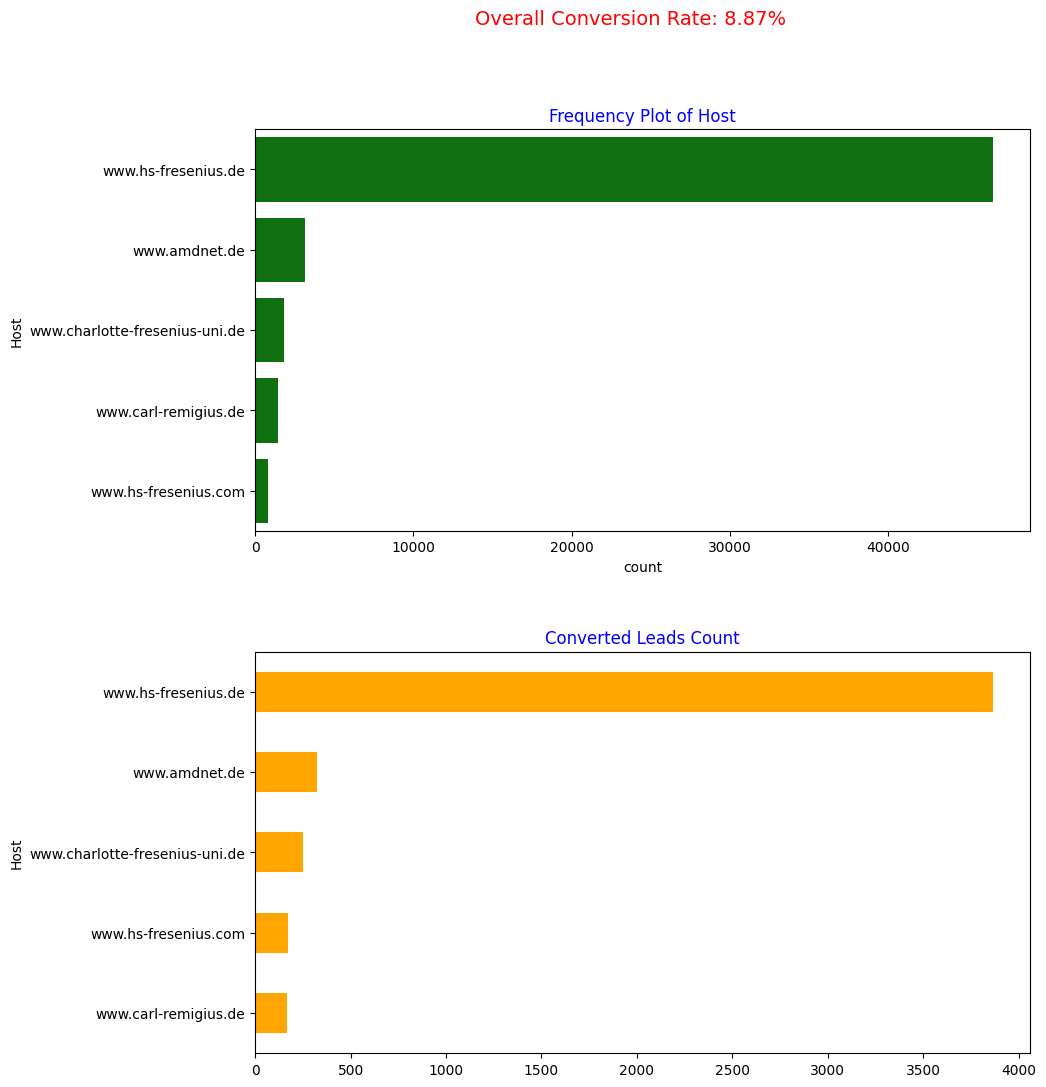

In [ ]:
plot_frequency_and_percentage('Host', df, df, True, 6)

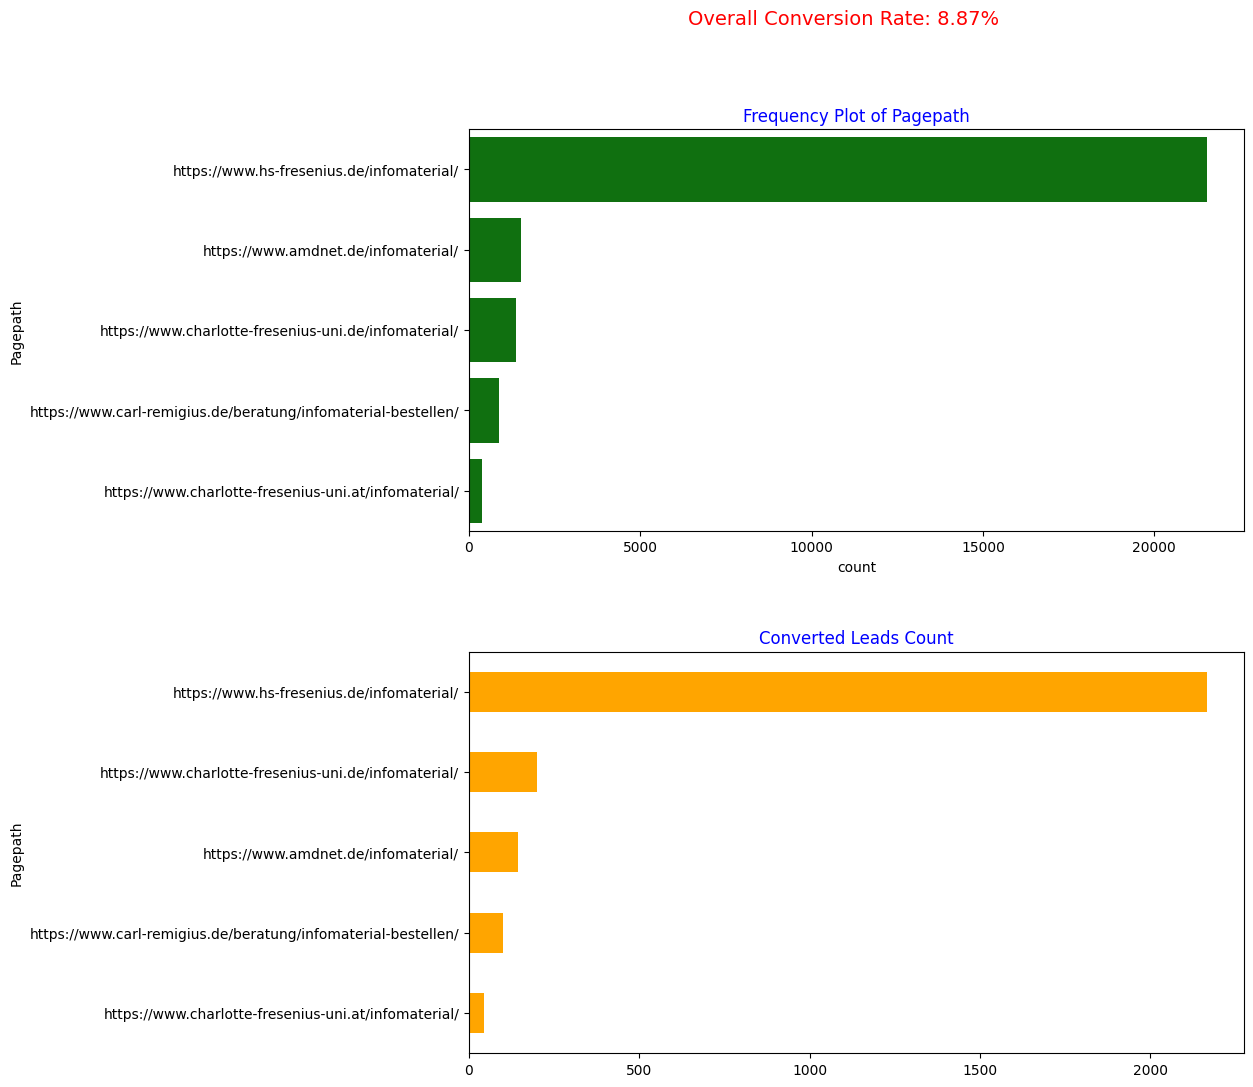

In [ ]:
plot_frequency_and_percentage('Pagepath', df, df, True, 6)

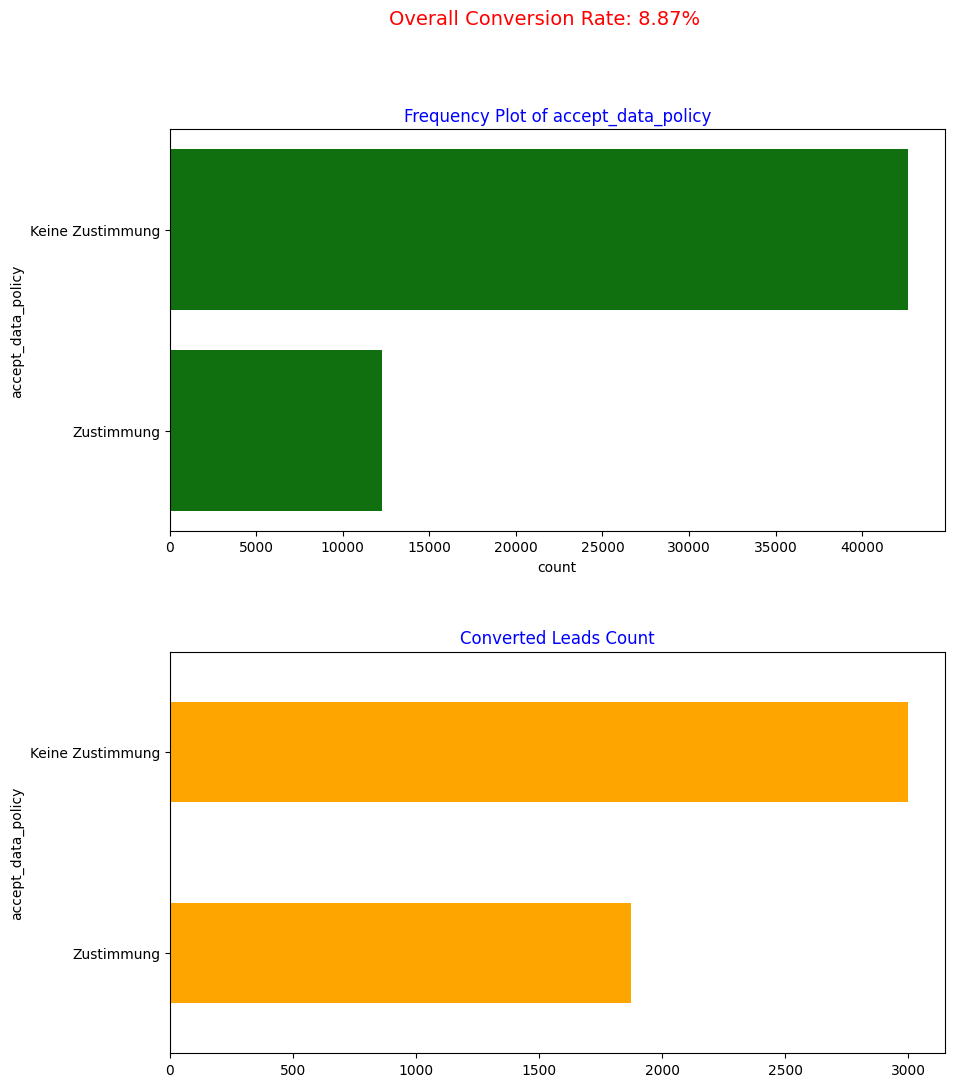

In [ ]:
plot_frequency_and_percentage('accept_data_policy', df, df, True, 6)

In [ ]:
filtered_df = df[df['is_converted'] == True]

# Step 3: Calculate the mean of 's_onTime' for the filtered DataFrame
s_onTime_mean_filtered = filtered_df['Time_on_Site'].mean()
print(s_onTime_mean_filtered)

3417.013344282488


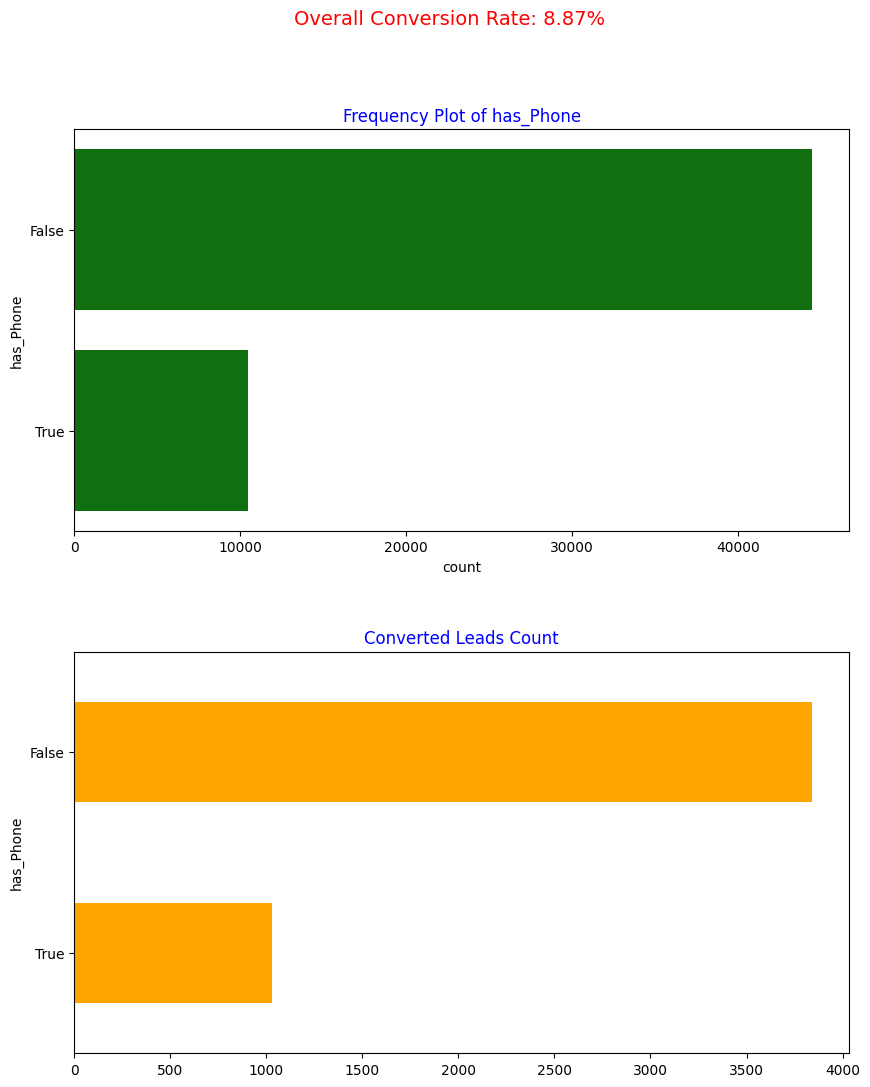

In [ ]:
plot_frequency_and_percentage('has_Phone', df, df, True, 6)

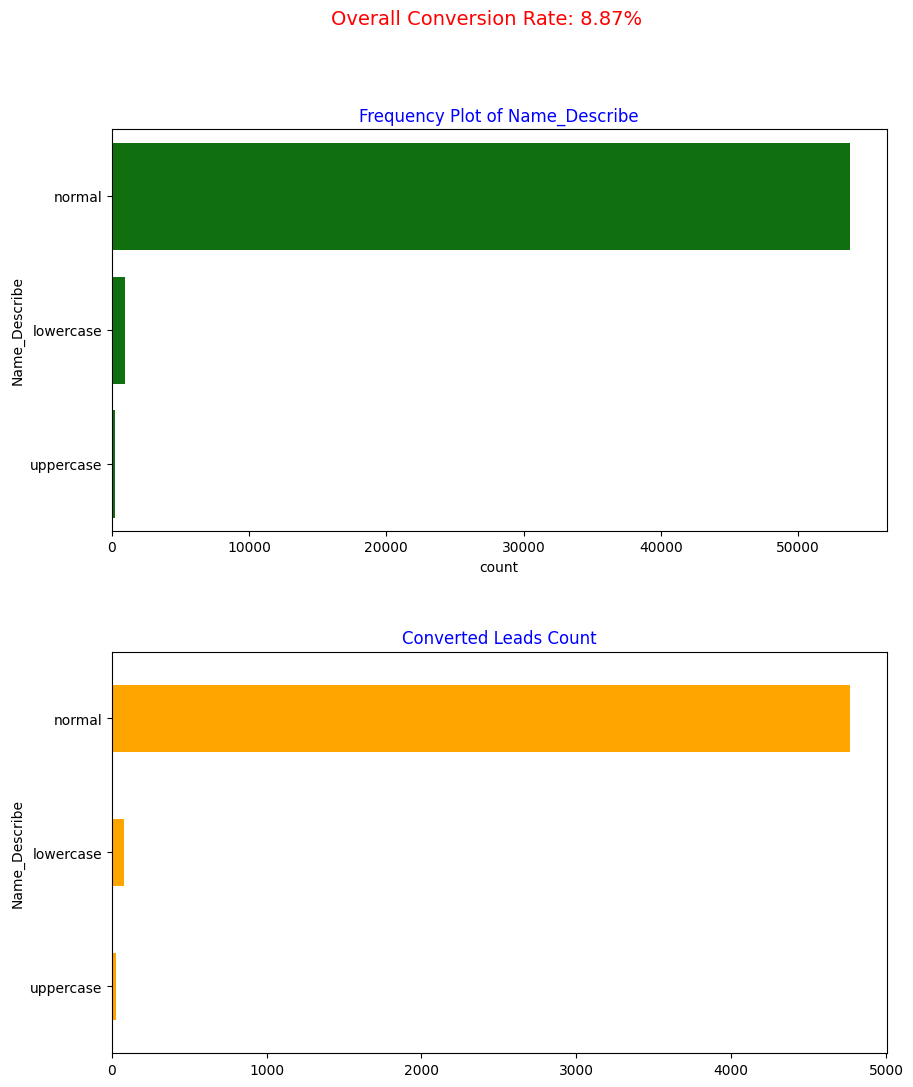

In [ ]:
plot_frequency_and_percentage('Name_Describe', df, df, True, 6)

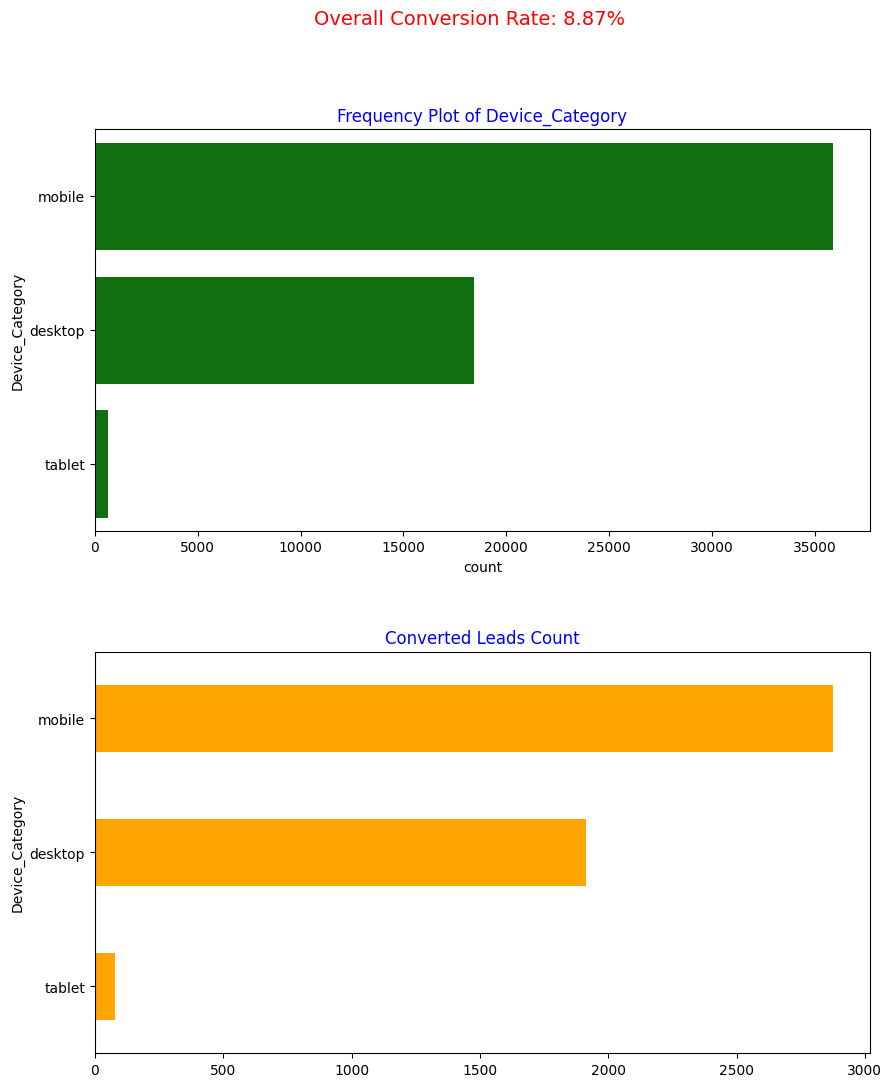

In [ ]:
plot_frequency_and_percentage('Device_Category', df, df, True, 6)

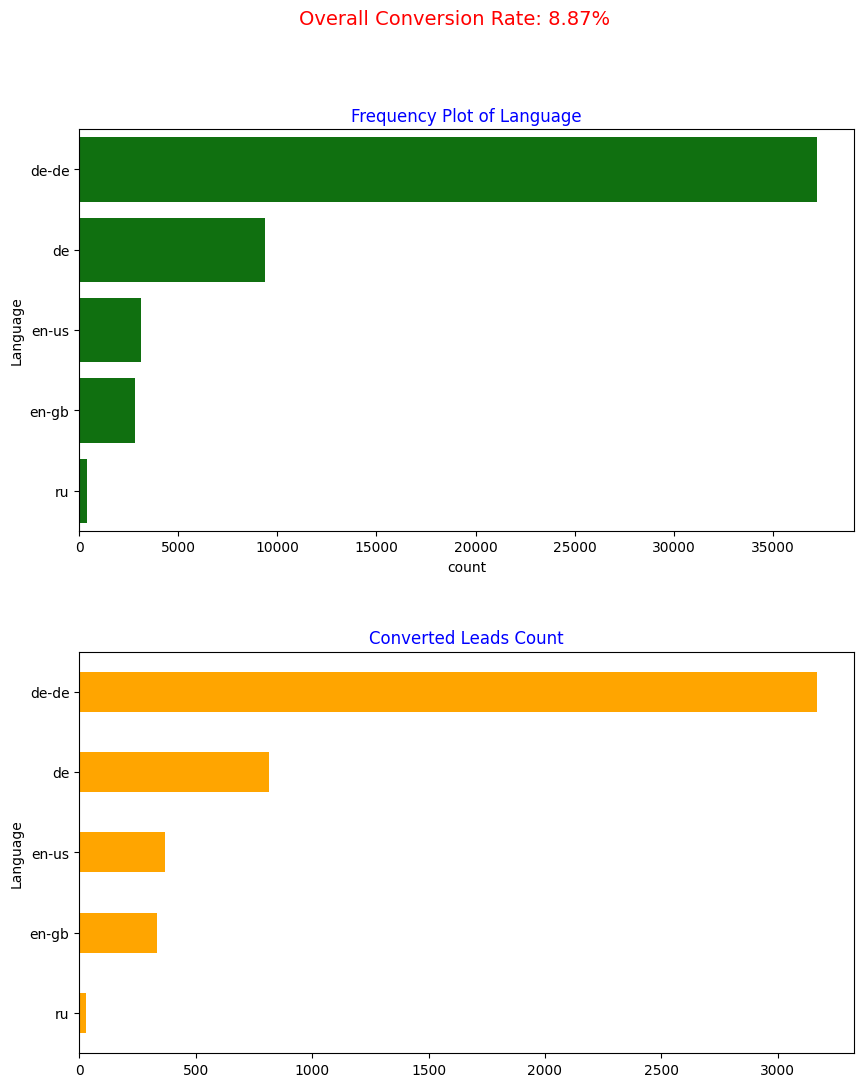

In [ ]:
plot_frequency_and_percentage('Language', df, df, True, 6)

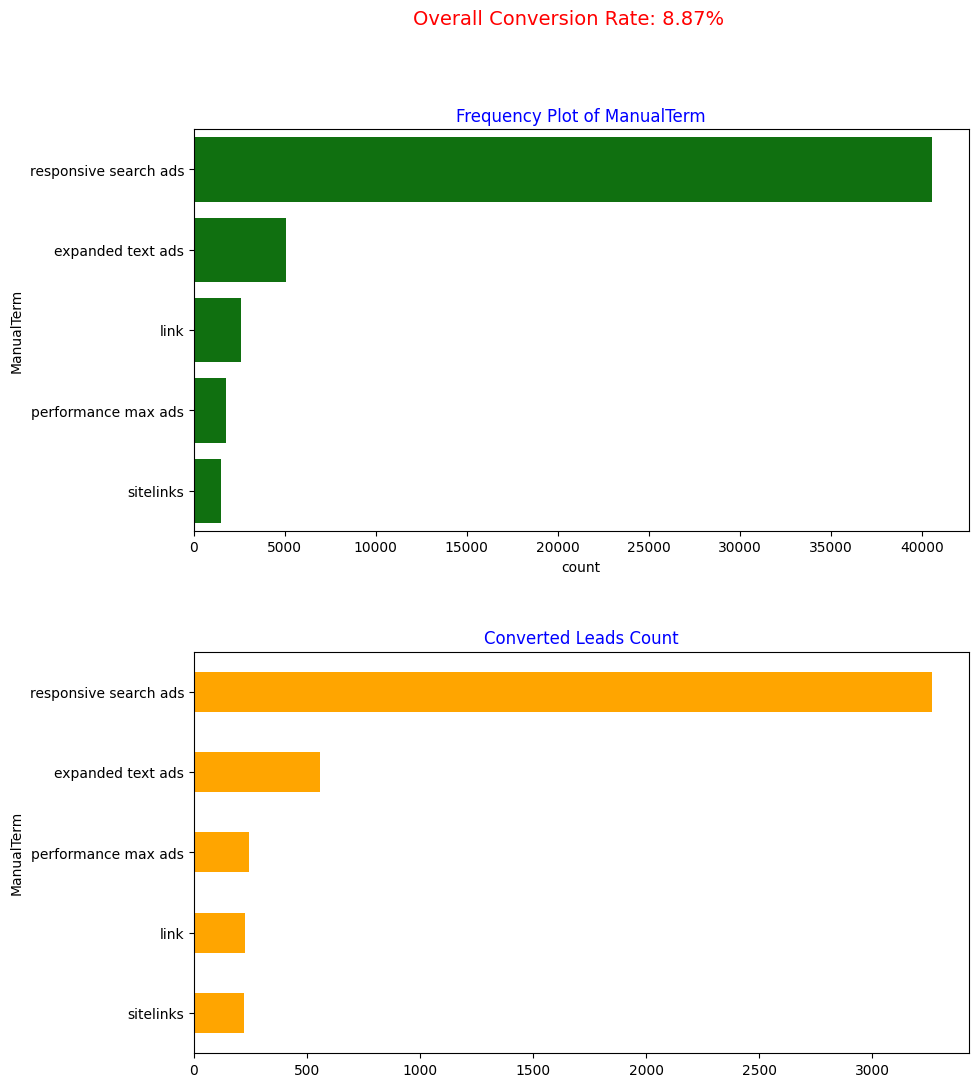

In [ ]:
plot_frequency_and_percentage('ManualTerm', df, df, True, 6)

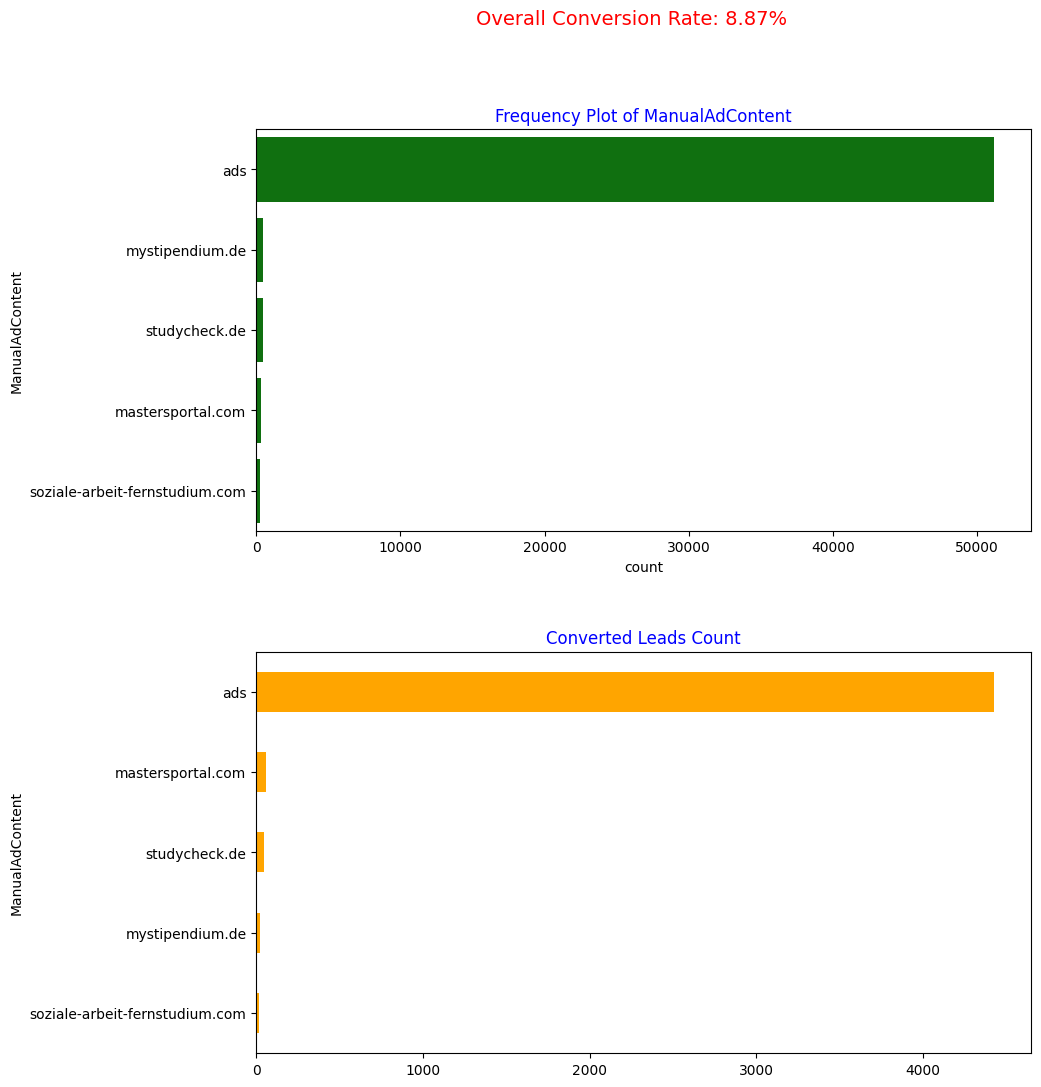

In [ ]:
plot_frequency_and_percentage('ManualAdContent', df, df, True, 6)

In [ ]:
# Import necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder, StandardScaler
import category_encoders as ce

In [ ]:
df.dtypes

Domain                    object
Name_Describe             object
has_Phone                boolean
Gender                    object
Lead_Source               object
Lead_Source_Detail        object
Study_Model               object
Type_of_Study_Program     object
Conversion_Type           object
Study_Location            object
Faculty                   object
Study_Program             object
Semester                  object
is_converted             boolean
Host                      object
Pagepath                  object
Time_on_Site               Int64
ManualTerm                object
Browser                   object
Operating_System          object
Device                    object
Language                  object
ManualAdContent           object
Bounce                    object
accept_data_policy        object
Device_Category           object
dtype: object

In [ ]:
df.nunique()

Domain                    2856
Name_Describe                3
has_Phone                    2
Gender                       3
Lead_Source                 12
Lead_Source_Detail         146
Study_Model                  3
Type_of_Study_Program        6
Conversion_Type              2
Study_Location              18
Faculty                      7
Study_Program              172
Semester                     2
is_converted                 2
Host                         9
Pagepath                 20866
Time_on_Site               629
ManualTerm                  16
Browser                      8
Operating_System            68
Device                     184
Language                    35
ManualAdContent             43
Bounce                       2
accept_data_policy           2
Device_Category              3
dtype: int64

In [ ]:
# Create a copy of the dataframe to work with
df_encoded = df.copy()

# Step 1: Drop 'is_converted' column from df_encoded and assign to X_
X = df_encoded.drop(columns=['is_converted'])

# Step 2: Extract 'is_converted' column from df_encoded and assign to y
y = df_encoded['is_converted']

In [ ]:
# Step 3: Label Encoding for specified column
'''
label_features = ['has_Phone', 'Conversion_Type', 'Semester', 'Bounce', 'accept_data_policy']
label_encoder = LabelEncoder()
for col in label_features:
    X[col] = label_encoder.fit_transform(X[col])
'''
# Step 4: Binary Encoding for specified columns
binary_features = ['Pagepath', 'Domain']
encoder_target = ce.TargetEncoder(cols=binary_features)
X = encoder_target.fit_transform(X, y)

# Step 5: Frequency/Count Encoding for specified columns

one_hot_features=[
    'Lead_Source', 'Lead_Source_Detail', 'Study_Location', 'Faculty',
    'Study_Program', 'Host', 'ManualTerm', 'Operating_System', 'Device',
    'Language', 'ManualAdContent', 'Name_Describe', 'Gender', 'Study_Model',
    'Type_of_Study_Program', 'Browser', 'Device_Category','has_Phone', 'Conversion_Type', 'Semester', 'Bounce', 'accept_data_policy']

X = pd.get_dummies(X, columns=one_hot_features)
'''
for col in count_features:
    if col in X.columns:
        count_encoding = X[col].value_counts()
        X[col] = X[col].map(count_encoding)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame"

label_features = ['has_Phone', 'Conversion_Type', 'Semester', 'Bounce', 'accept_data_policy', 'Lead_Source', 'Lead_Source_Detail', 'Study_Location', 'Faculty',
    'Study_Program', 'Host', 'ManualTerm', 'Operating_System', 'Device',
    'Language', 'ManualAdContent', 'Name_Describe', 'Gender', 'Study_Model',
    'Type_of_Study_Program', 'Browser', 'Device_Category','Pagepath', 'Domain']
label_encoder = LabelEncoder()
for col in label_features:
    X[col] = label_encoder.fit_transform(X[col])
'''


# Step 6: Scaling the dataframe
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Step 7: Define the encoded and scaled dataframe as X_prep
X_en = df_scaled

In [ ]:
# Define categorical features indices for SMOTENC, excluding 'Time_on_Site'
categorical_columns = ['has_Phone', 'Conversion_Type', 'Semester', 'Bounce', 'accept_data_policy', 'Lead_Source', 'Lead_Source_Detail', 'Study_Location', 'Faculty',
    'Study_Program', 'Host', 'ManualTerm', 'Operating_System', 'Device',
    'Language', 'ManualAdContent', 'Name_Describe', 'Gender', 'Study_Model',
    'Type_of_Study_Program', 'Browser', 'Device_Category','Pagepath', 'Domain']
print(categorical_columns)
all_columns = X_en.columns.tolist()
categorical_indices = [all_columns.index(col) for col in categorical_columns if col in all_columns]
categorical_indices

['has_Phone', 'Conversion_Type', 'Semester', 'Bounce', 'accept_data_policy', 'Lead_Source', 'Lead_Source_Detail', 'Study_Location', 'Faculty', 'Study_Program', 'Host', 'ManualTerm', 'Operating_System', 'Device', 'Language', 'ManualAdContent', 'Name_Describe', 'Gender', 'Study_Model', 'Type_of_Study_Program', 'Browser', 'Device_Category', 'Pagepath', 'Domain']


[1, 0]

In [ ]:
lb = LabelEncoder()
lb.fit(y)
y_encoded = lb.transform(y)
print("Encoded labels:",lb.classes_)
y_en = pd.Series(y_encoded)

Encoded labels: [0. 1.]


In [ ]:
# Ensure all indices are integers and within valid range
n_features = X_en.shape[1]
validated_indices = []
for index in categorical_indices:
    if not isinstance(index, int):
        raise TypeError(f"Index {index} is not an integer.")
    if index < 0 or index >= n_features:
        raise IndexError(f"Index {index} is out of bounds for the dataset with {n_features} features.")
    validated_indices.append(index)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_en, y_en, test_size=0.2, stratify=y, random_state=42)


print("Training Data Shape : ", X_train.shape, y_train.shape)
print("Test Data Shape : ", X_test.shape, y_test.shape)

Training Data Shape :  (43947, 749) (43947,)
Test Data Shape :  (10987, 749) (10987,)


In [ ]:
# Print the validated indices and their types for verification
print("Validated Indices:", validated_indices)
print("Indices Types:", [type(index) for index in validated_indices])

Validated Indices: [1, 0]
Indices Types: [<class 'int'>, <class 'int'>]


In [ ]:
smotenc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train, y_train = smotenc.fit_resample(X_train, y_train)




In [ ]:
print("Smote Train Data : ", X_train.shape, y_train.shape)

Smote Train Data :  (80100, 749) (80100,)


In [ ]:
mi_classification = mutual_info_classif(X_train, y_train ,discrete_features='auto')

# Create a pandas Series with the MI scores and the feature names
mi_series = pd.Series(mi_classification, index=X.columns)

# Sort the MI scores in descending order and convert to a DataFrame
data_mi = mi_series.sort_values(ascending=False).to_frame(name='MI')

# Display the DataFrame
print(data_mi)

                                                 MI
Time_on_Site                               0.252902
Pagepath                                   0.238244
accept_data_policy_Zustimmung              0.140697
accept_data_policy_Keine Zustimmung        0.139953
Semester_Wintersemester                    0.118991
...                                             ...
Operating_System_Android 8.1.0             0.000000
Operating_System_Android 9                 0.000000
Lead_Source_Detail_mygermanuniversity.com  0.000000
Device_KH7                                 0.000000
Lead_Source_Detail_masterstudies.com       0.000000

[749 rows x 1 columns]


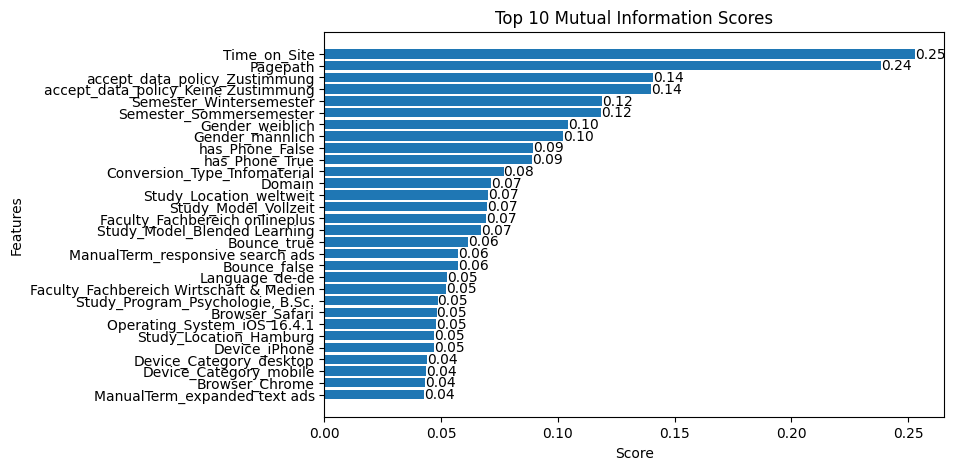

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the Mutual Information scores
def plot_mi_scores(scores):
    # Select top 10 scores
    top_scores = scores.sort_values(ascending=False).head(30)
    sorted_scores = top_scores.sort_values(ascending=True)
    width = np.arange(len(sorted_scores))
    ticks = sorted_scores.index
    plt.barh(width, sorted_scores)
    plt.yticks(width, ticks)
    plt.title("Top 10 Mutual Information Scores")
    plt.xlabel("Score")
    plt.ylabel("Features")

    # Add text annotations for the bar values
    for index, value in enumerate(sorted_scores):
        plt.text(value, index, f'{value:.2f}', va='center', ha='left')

    plt.show()

# Plot the Mutual Information scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_series)

In [ ]:
from sklearn.feature_selection import RFE
#Step 1: Initialize the model and RFE
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=classifier, n_features_to_select=10)  # Select the top 10 features

# Step 2: Fit the RFE model
rfe.fit(X_train, y_train)

# Step 3: Get the ranking of features and select the top features
ranking = rfe.ranking_
selected_features = X_train.columns[rfe.support_]

# Step 4: Create a reduced dataset with only the top features
X_train_rfe_selected  = X_train[selected_features]

# Step 5: Plot the selected features' importance
def plot_rfe_selected_features(ranking, selected_features):
    feature_ranking = pd.Series(ranking, index=X_train.columns)
    top_features = feature_ranking[feature_ranking == 1].index
    scores = pd.Series(1, index=top_features)  # RFE doesn't provide actual scores, just ranking
    sorted_scores = scores.sort_values(ascending=True)

    width = np.arange(len(sorted_scores))
    ticks = sorted_scores.index
    plt.barh(width, sorted_scores)
    plt.yticks(width, ticks)
    plt.title("Top Selected Features by RFE")
    plt.xlabel("Ranking")
    plt.ylabel("Features")
    plt.show()

plt.figure(dpi=100, figsize=(8, 5))
plot_rfe_selected_features(ranking, selected_features)

# X_train_reduced now contains only the top features selected by RFE
print("Selected features:", selected_features)

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Features and their VIF values after RFE:
                               feature       VIF
0                         Time_on_Site  1.002914
1                             Pagepath  1.068906
2        accept_data_policy_Zustimmung       inf
3  accept_data_policy_Keine Zustimmung       inf
4              Semester_Wintersemester       inf
5              Semester_Sommersemester       inf
6                      Gender_männlich  1.004810
7         Conversion_Type_Infomaterial  1.029816
8                               Domain  1.059173
9                 Study_Model_Vollzeit  1.107599

Features selected after removing high VIF features:
0                    Time_on_Site
1                        Pagepath
6                 Gender_männlich
7    Conversion_Type_Infomaterial
8                          Domain
9            Study_Model_Vollzeit
Name: feature, dtype: object


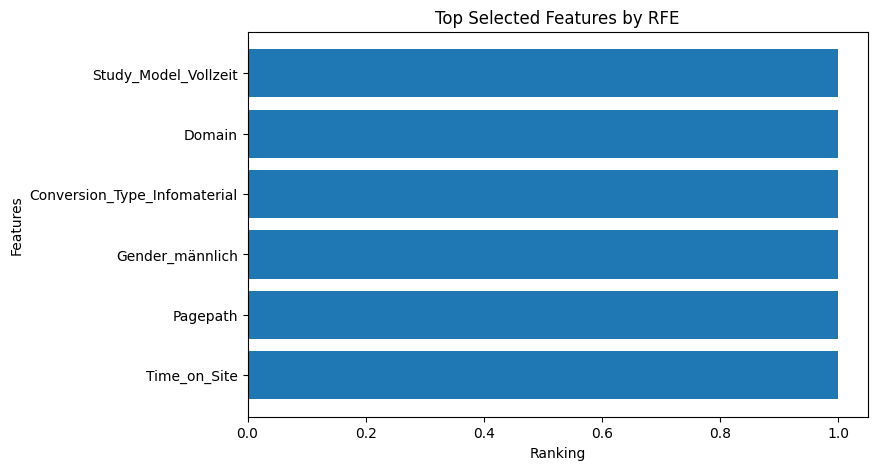

In [ ]:
# Calculate VIF for the features selected by RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor# Step 2: Calculate VIF for the selected features
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for the features selected by RFE
vif_data = calculate_vif(X_train_reduced)

# Step 3: Evaluate and potentially remove features with high VIF values
# Threshold for VIF value (commonly 10, but can be adjusted based on domain knowledge)
vif_threshold = 10

# Filtering out the features with VIF greater than the threshold
features_to_keep = vif_data[vif_data["VIF"] < vif_threshold]["feature"]
X_train_reduced = X_train_reduced[features_to_keep]

# Print the features with their VIF values
print("Features and their VIF values after RFE:")
print(vif_data)

print("\nFeatures selected after removing high VIF features:")
print(features_to_keep)

# Step 4: Plot the selected features' importance from RFE
def plot_rfe_selected_features(selected_features):
    scores = pd.Series(1, index=selected_features)  # RFE doesn't provide actual scores, just ranking
    sorted_scores = scores.sort_values(ascending=True)

    width = np.arange(len(sorted_scores))
    ticks = sorted_scores.index
    plt.barh(width, sorted_scores)
    plt.yticks(width, ticks)
    plt.title("Top Selected Features by RFE")
    plt.xlabel("Ranking")
    plt.ylabel("Features")
    plt.show()

plt.figure(dpi=100, figsize=(8, 5))
plot_rfe_selected_features(features_to_keep)

# X_train_reduced now contains only the top features selected by RFE and filtered by VIF

In [ ]:
# Check lengths of X_train_resampled and y_train_resampled
len_X_train_resampled = len(X_train)
len_y_train_resampled = len(y_train)

print(f"Length of X_train_resampled: {len_X_train_resampled}")
print(f"Length of y_train_resampled: {len_y_train_resampled}")

if len_X_train_resampled != len_y_train_resampled:
    raise ValueError("Inconsistent lengths: X_train_resampled and y_train_resampled must have the same number of samples.")


In [ ]:
filtered_data_mi = data_mi[data_mi['MI'] > 0.01]

X_train = X_train[filtered_data_mi.index]
X_test= X_test[filtered_data_mi.index]
y_train = y_train



In [ ]:
# Check lengths of X_train and X_test
len_X_train = len(X_train)
len_X_test = len(X_test)

print(f"Length of X_train: {len_X_train}")
print(f"Length of X_test: {len_X_test}")

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold
cv_split = StratifiedKFold(n_splits=10)

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, proba)

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # Cross Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall (Sensitivity): {recall}")
    print(f"F1-Score: {f1}")
    print(f"Specificity: {specificity}")
    print(f"ROC AUC: {roc_auc}")
    print(f"Cross Validation Accuracy: {cv_scores.mean()}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix Visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity,
        'cv_accuracy': cv_scores.mean()
    }


In [ ]:

# Pipelines for each model without hyperparameter tuning
pipeline_lgb = Pipeline([

    ('clf', lgb.LGBMClassifier())
])

pipeline_xgb = Pipeline([
    ('clf', xgb.XGBClassifier())
])

pipeline_rf = Pipeline([
    ('clf', RandomForestClassifier())
])


pipeline_dt = Pipeline([
    ('clf', DecisionTreeClassifier())
])



In [ ]:

model_performance = {}

In [ ]:
# Train and evaluate LightGBM
model_performance['LightGBM'] = evaluate_model(pipeline_lgb.fit(X_train, y_train), X_test, y_test, "LightGBM")


LightGBMError: Do not support special JSON characters in feature name.

XGBoost Metrics:
Accuracy: 0.9280058250659871
Precision: 0.7183770883054893
Recall (Sensitivity): 0.30903490759753593
F1-Score: 0.4321608040201005
Specificity: 0.9882153200838909
ROC AUC: 0.8639148470438123
Cross Validation Accuracy: 0.9455430711610487


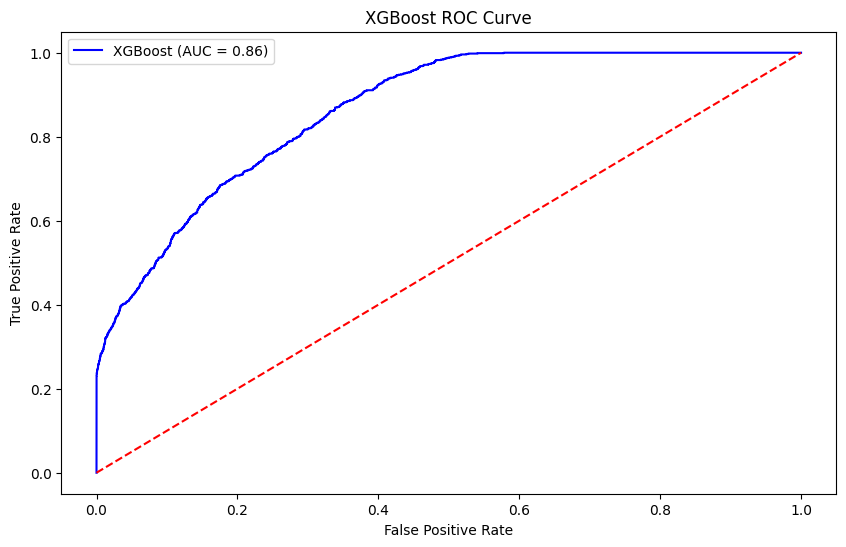

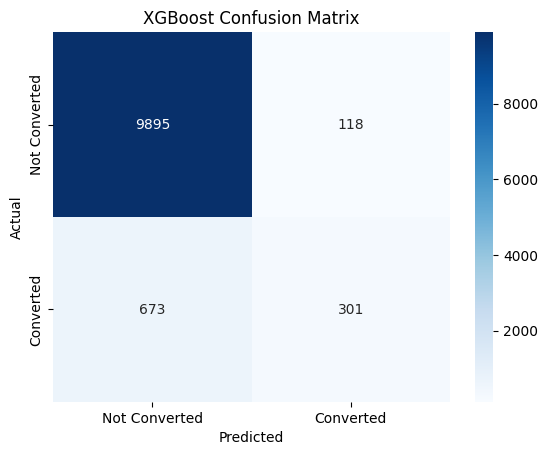

In [ ]:
# Train and evaluate XGBoost
model_performance['XGBoost'] = evaluate_model(pipeline_xgb.fit(X_train, y_train),X_test, y_test, "XGBoost")


RandomForest Metrics:
Accuracy: 0.9146263766269227
Precision: 0.5375
Recall (Sensitivity): 0.2648870636550308
F1-Score: 0.35488308115543327
Specificity: 0.9778288225307101
ROC AUC: 0.8280765292593961
Cross Validation Accuracy: 0.9463920099875157


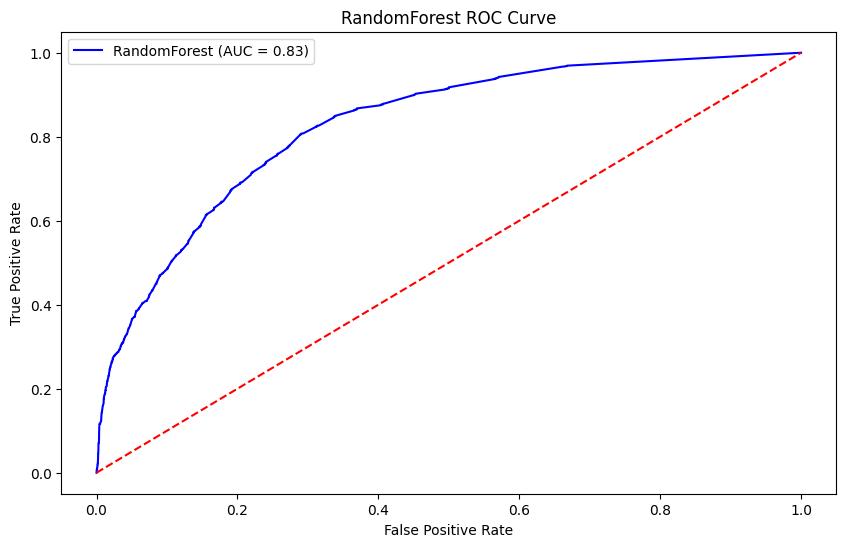

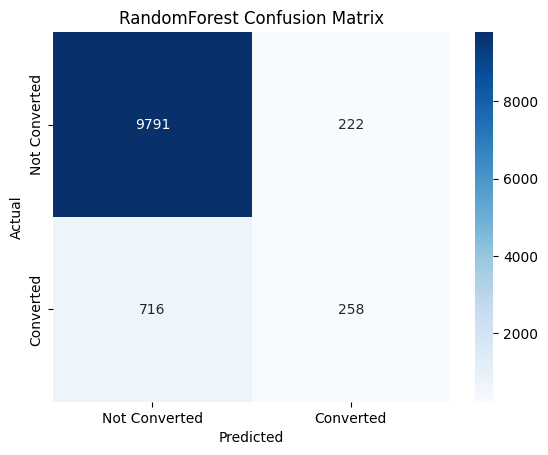

In [ ]:
# Train and evaluate RandomForest
model_performance['RandomForest'] = evaluate_model(pipeline_rf.fit(X_train, y_train), X_test, y_test, "RandomForest")

DecisionTree Metrics:
Accuracy: 0.8787658141439884
Precision: 0.3317669172932331
Recall (Sensitivity): 0.3624229979466119
F1-Score: 0.34641805691854766
Specificity: 0.9289923099970039
ROC AUC: 0.6515718990363862
Cross Validation Accuracy: 0.9173782771535581


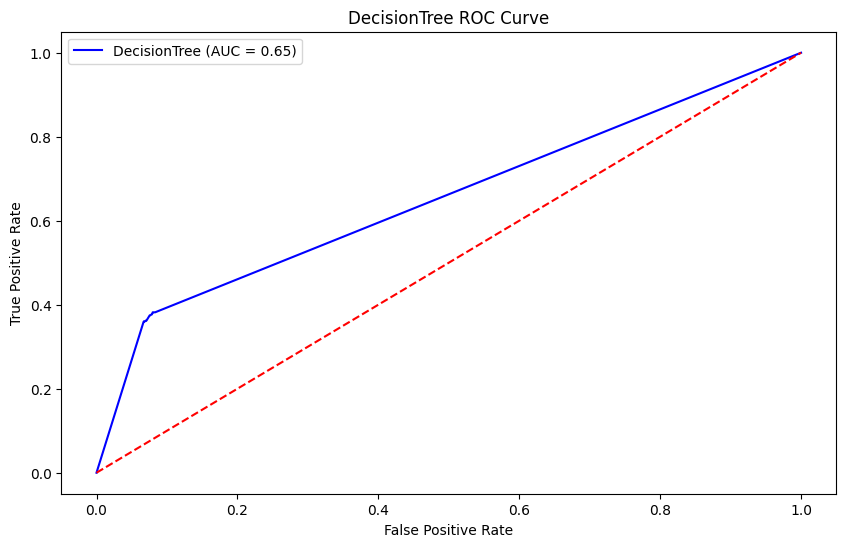

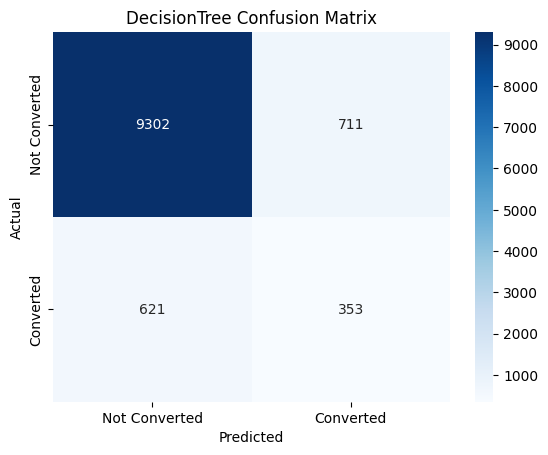

In [ ]:
# Train and evaluate DecisionTree
model_performance['DecisionTree'] = evaluate_model(pipeline_dt.fit(X_train, y_train), X_test, y_test, "DecisionTree")


In [ ]:
# Convert the model performance dictionary to a DataFrame
results_df = pd.DataFrame(model_performance).T

# Save the DataFrame to an Excel file
results_df.to_excel('model_performance_results.xlsx', index=True)
print("Model performance results saved to 'model_performance_results3.xlsx'.")

Model performance results saved to 'model_performance_results3.xlsx'.


In [ ]:
# Determine the best model based on ROC AUC
best_model_name = max(model_performance, key=lambda k: model_performance[k]['roc_auc'])
print(f"The best model is {best_model_name} based on ROC AUC.")


The best model is XGBoost based on ROC AUC.


In [ ]:
 #Define hyperparameters for Grid Search
param_grid_lgb = {
    'clf__num_leaves': [31, 50],
    'clf__learning_rate': [0.1, 0.01],
    'clf__n_estimators': [100, 200]
}

param_grid_xgb = {
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.1, 0.01],
    'clf__n_estimators': [100, 200]
}

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}

param_grid_dt = {
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 10, 20]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
#Function to perform Grid Search
def perform_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search

In [ ]:
# Perform Grid Search for each model
#grid_search_lgb = perform_grid_search(pipeline_lgb, param_grid_lgb, X_train, y_train)
grid_search_xgb = perform_grid_search(pipeline_xgb, param_grid_xgb, X_train, y_train)
grid_search_rf = perform_grid_search(pipeline_rf, param_grid_rf, X_train, y_train)
grid_search_dt = perform_grid_search(pipeline_dt, param_grid_dt, X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
# Evaluate models and store performance
model_performance = {}
# Function to evaluate model
def evaluate_model(grid_search, X_test, y_test, model_name, X_train, y_train):
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0][0]
    fp = cm[0][1] if len(cm[0]) > 1 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall (Sensitivity): {recall}")
    print(f"F1-Score: {f1}")
    print(f"Specificity: {specificity}")
    print(f"ROC AUC: {roc_auc}")
    print(f"Cross Validation Accuracy: {cv_scores.mean()}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix Visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity,
        'cv_accuracy': cv_scores.mean(),
        'best_params': grid_search.best_params_
    }

In [ ]:
evaluate_model(grid_search_lgb, X_test, y_test, 'LightGBM')

NameError: name 'grid_search_lgb' is not defined

XGBoost Metrics:
Accuracy: 0.9276417584417949
Precision: 0.916651063681854
Recall (Sensitivity): 0.9276417584417949
F1-Score: 0.9133569219526533
Specificity: 0.9892140217716968
ROC AUC: 0.8665127531334521
Cross Validation Accuracy: 0.9461423220973784


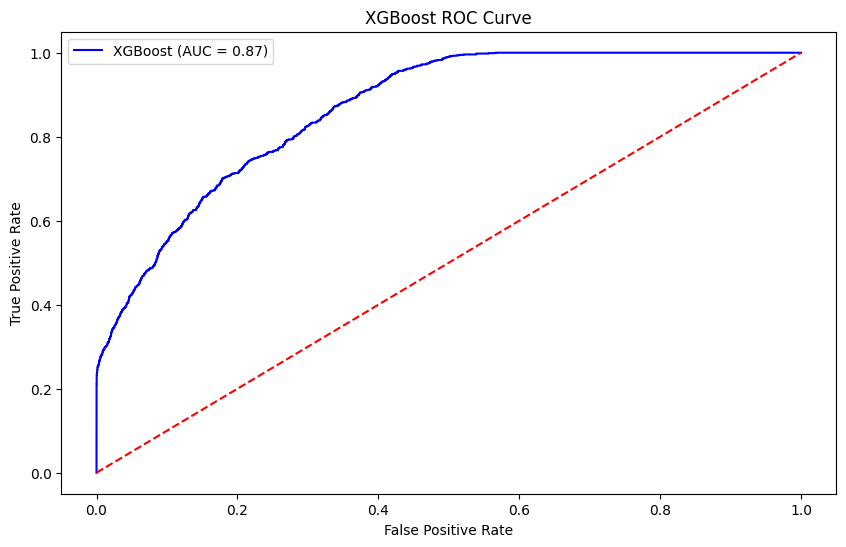

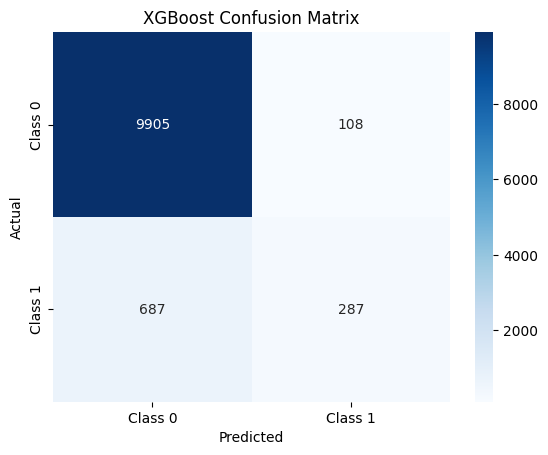

In [ ]:
model_performance['XGBoost'] = evaluate_model(grid_search_xgb, X_test, y_test, 'XGBoost', X_train, y_train)

RandomForest Metrics:
Accuracy: 0.9131701101301538
Precision: 0.8951957411534847
Recall (Sensitivity): 0.9131701101301538
F1-Score: 0.8999907354219168
Specificity: 0.9763307699990013
ROC AUC: 0.8350573412674407
Cross Validation Accuracy: 0.9463670411985019


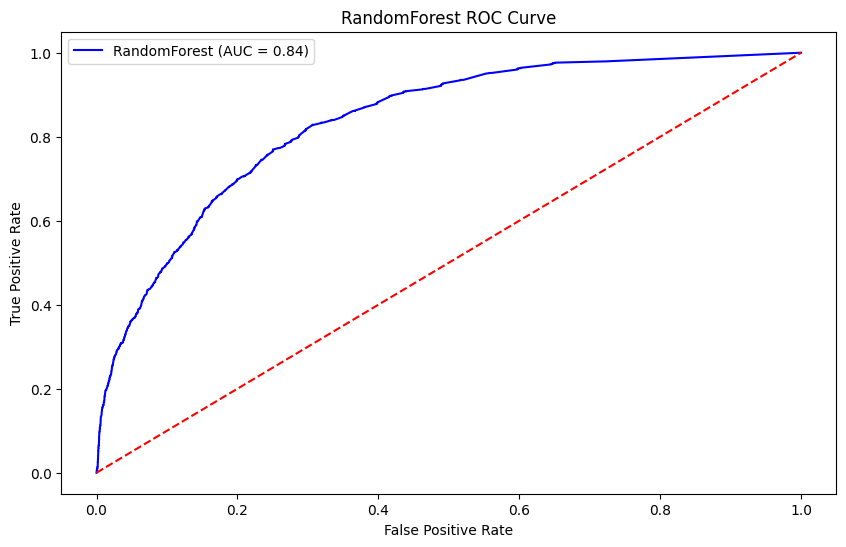

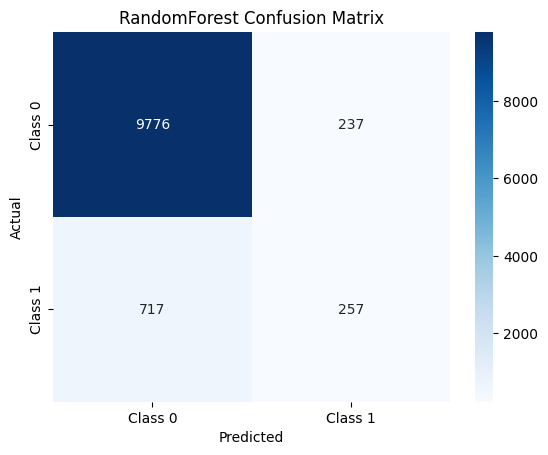

In [ ]:
model_performance['RandomForest'] = evaluate_model(grid_search_rf, X_test, y_test, 'RandomForest', X_train, y_train)

DecisionTree Metrics:
Accuracy: 0.9000637116592336
Precision: 0.8918111452920059
Recall (Sensitivity): 0.9000637116592336
F1-Score: 0.8955360586218807
Specificity: 0.9539598521921502
ROC AUC: 0.7860732792749302
Cross Validation Accuracy: 0.914868913857678


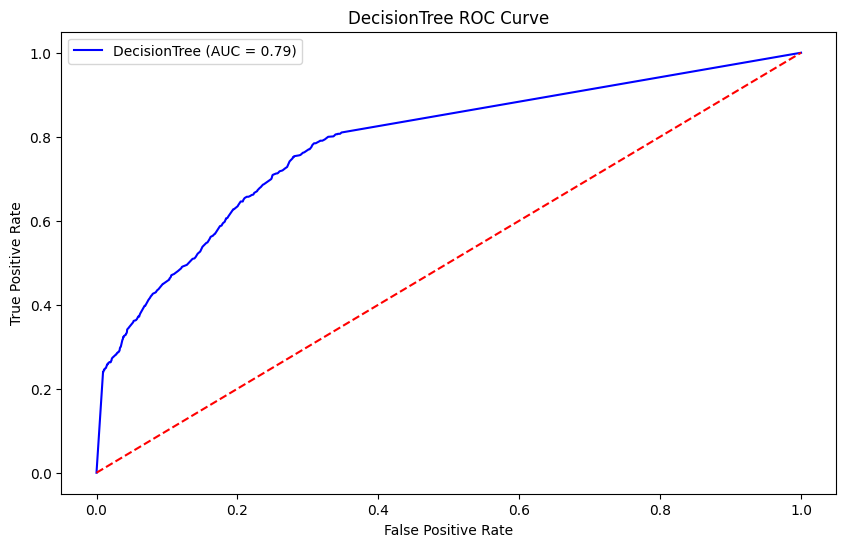

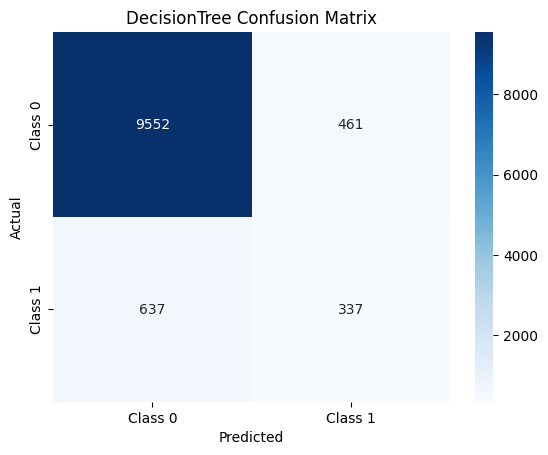

In [ ]:
model_performance['DecisionTree'] = evaluate_model(grid_search_dt, X_test, y_test, 'DecisionTree', X_train, y_train)

In [ ]:
# Convert the model performance dictionary to a DataFrame
results_df = pd.DataFrame(model_performance).T

# Save results to an Excel file
results_df.to_excel('model_performance_metrics.xlsx', index=True)

# Print results for each model
print("Model Performance Metrics:")
print(results_df)


Model Performance Metrics:
              accuracy precision    recall        f1   roc_auc specificity  \
XGBoost       0.927642  0.916651  0.927642  0.913357  0.866513    0.989214   
RandomForest   0.91317  0.895196   0.91317  0.899991  0.835057    0.976331   
DecisionTree  0.900064  0.891811  0.900064  0.895536  0.786073     0.95396   

             cv_accuracy                                        best_params  
XGBoost         0.946142  {'clf__learning_rate': 0.1, 'clf__max_depth': ...  
RandomForest    0.946367  {'clf__max_depth': None, 'clf__n_estimators': ...  
DecisionTree    0.914869  {'clf__max_depth': 20, 'clf__min_samples_split...  
